In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

import os
from utils import tools
from sklearn import preprocessing
from torchviz import make_dot, make_dot_from_trace


# import FlowNetC
from networks import FlowNetC

from PIL import Image
import numpy as np
import pandas as pd

# import flowlib

from PIL import Image

import tqdm
import cv2
import csv
import time

In [206]:
cap = cv2.VideoCapture('data/caolin_foot_trial1-4.mp4')
name = 'caolin'

framerate = cap.get(5)
total_image = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'The oringinal framerate is {cap.get(5)} with frame resolution of: {cap.get(3), cap.get(4)}')
print(f'The total number of frame in this video is {total_image}')

The oringinal framerate is 25.0 with frame resolution of: (768.0, 576.0)
The total number of frame in this video is 17155


In [207]:
count = 1
while(cap.isOpened()):
    frameID = cap.get(1) # get the current frame number
    ret, frame = cap.read()
    
    if(ret != True):
        print(f'We\'ve gotten {int(frameID/5)+1} frames from this video.')
        break
    if (frameID % int(framerate/5) == 0):
        frame = frame[64:, 170:600 , :]
        filename = 'Train_1/'+ name + "_frame%04d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

We've gotten 3432 frames from this video.


## Building Dataset

In [13]:
image_files = dataset.image_files

In [183]:
class MyDataset:
    
    def __init__(self, num_train_img = 3400, base_dir = '/home/projectx/Documents/GitHub repos/VINET_modification/', sequence = 'Train_1/'):  # base_dir(image) and sequence(lstm) are directories
        self.base_dir = base_dir
        self.sequence = sequence
        self.base_path_img = self.base_dir + self.sequence
        
        self.image_files = os.listdir(self.base_path_img)
        self.image_files.sort()
        self.image_files = self.image_files[0:num_train_img]
        
        # normalization for lstm data
        self.train_scaler = preprocessing.StandardScaler()
        
        ## Omega.7 and load cells
        self.input_lstm = self.read_OMEGA7_LC()
        
        
        self.imu_seq_len = 20
    
    def read_OMEGA7_LC(self, path='data/result_1.csv'):
        # read csv data
        df = pd.read_csv(path,header = None)
        df = df[:874300]
        
        # take moving average of every 10 data points
        new_df = df.groupby(df.index//10).mean()
        array_input = np.array(new_df)
        
        # normalization
        array_input_scaled = self.train_scaler.fit_transform(array_input)
        
        input_lstm  = Variable(torch.from_numpy(array_input_scaled).type(torch.FloatTensor))
        input_lstm = input_lstm[:80000,:]
        
        
        
        # reshape to (num_dataset, sequence_length, feature_size)
        input_lstm = input_lstm.view(-1,20,11)
        
        return np.array(input_lstm)
    
    
    def get_input_lstm(self):
        return self.input_lstm
    
    def __len__(self):
        return len(self.image_files)
    
    def load_img_bat(self, idx, batch):
        batch_x = []
        batch_input_lstm = []
        for i in range(batch):
            x_data_np_1 = np.array(Image.open(self.base_path_img + self.image_files[idx + i]))
            x_data_np_2 = np.array(Image.open(self.base_path_img + self.image_files[idx+1 + i]))
            x_data_np_1 = x_data_np_1.reshape(3,512,430)
            x_data_np_2 = x_data_np_2.reshape(3,512,430)

#             ## 3 channels
#             x_data_np_1 = np.array([x_data_np_1, x_data_np_1, x_data_np_1])
#             x_data_np_2 = np.array([x_data_np_2, x_data_np_2, x_data_np_2])

            X = np.array([x_data_np_1, x_data_np_2])
            batch_x.append(X)
        
#           self.input_lstm of size: (num_dataset, sequence_length, feature_size)
            tmp = np.array(self.input_lstm[idx + i])
            batch_input_lstm.append(tmp)
            
        
        batch_x = np.array(batch_x)
        batch_input_lstm = np.array(batch_input_lstm)
        
        X = Variable(torch.from_numpy(batch_x).type(torch.FloatTensor).cuda())    
        X2 = Variable(torch.from_numpy(batch_input_lstm).type(torch.FloatTensor).cuda())    
        
        Y = X2[:,:,-3:]
        
     
        return X, X2 , Y.mean(1)

In [184]:
dataset = MyDataset()

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(80000, 11)

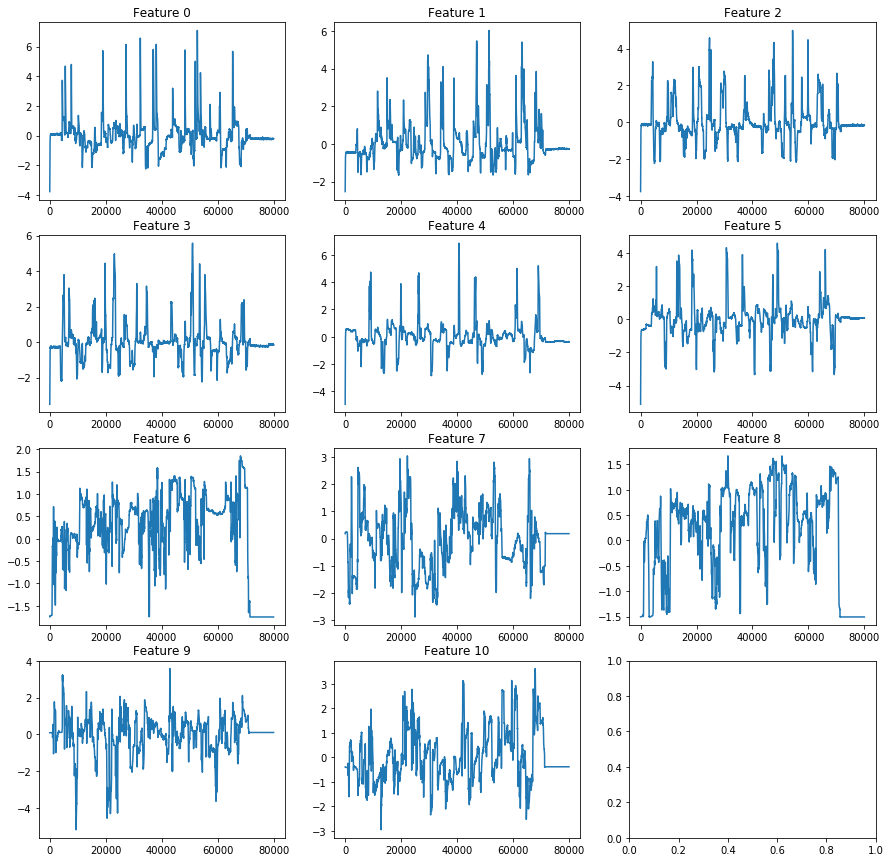

In [178]:
lstm_input = dataset.read_OMEGA7_LC()
lstm_input = lstm_input.reshape(4000*20, -1)
plot_feature_dim(lstm_input)
lstm_input.shape

In [154]:
def plot_feature_dim(lstm_input):
    fig, axs = plt.subplots(4,3,figsize=(15,15))

    for i in range(4):
        for j in range(3):
            if (i == 3 and j == 2):
                break

            x = np.arange(0,80000)
            axs[i,j].plot(x,lstm_input[:,i*3+j])
            axs[i,j].set_title(f'Feature {i*3+j}')

In [185]:
X, X2 , Y = dataset.load_img_bat(0,1)

In [186]:
X.size(), X2.size() , Y.size() 

(torch.Size([1, 2, 3, 512, 430]), torch.Size([1, 20, 11]), torch.Size([1, 3]))

In [208]:
class Vinet(nn.Module):
    def __init__(self):
        super(Vinet, self).__init__()
        self.rnn = nn.LSTM(
            input_size=57464,#49152,#24576, 
            hidden_size=1024,#64, 
            num_layers=2,
            batch_first=True)
        self.rnn.cuda()
        
        self.rnnIMU = nn.LSTM(
            input_size=11, 
            hidden_size=6,
            num_layers=2,
            batch_first=True)
        self.rnnIMU.cuda()
        
        self.linear1 = nn.Linear(1024, 128)
        self.linear2 = nn.Linear(128, 3)
        #self.linear3 = nn.Linear(128, 6)
        self.linear1.cuda()
        self.linear2.cuda()
        #self.linear3.cuda()
        
        # load checkpoint state from NVIDIA training
        checkpoint = None
        checkpoint_pytorch = 'FlowNet2-C_checkpoint.pth.tar'
        #checkpoint_pytorch = '/notebooks/data/model/FlowNet2-SD_checkpoint.pth.tar'
        if os.path.isfile(checkpoint_pytorch):
            print('pre_trained_weights found')
            checkpoint = torch.load(checkpoint_pytorch,\
                                map_location=lambda storage, loc: storage.cuda(0))
            pop_list = ["deconv5.0.weight", "deconv5.0.bias", "deconv4.0.weight", "deconv4.0.bias", "deconv3.0.weight", "deconv3.0.bias", "deconv2.0.weight", "deconv2.0.bias", "predict_flow6.weight", "predict_flow6.bias", "predict_flow5.weight", "predict_flow5.bias", "predict_flow4.weight", "predict_flow4.bias", "predict_flow3.weight", "predict_flow3.bias", "predict_flow2.weight", "predict_flow2.bias", "upsampled_flow6_to_5.weight", "upsampled_flow6_to_5.bias", "upsampled_flow5_to_4.weight", "upsampled_flow5_to_4.bias", "upsampled_flow4_to_3.weight", "upsampled_flow4_to_3.bias", "upsampled_flow3_to_2.weight", "upsampled_flow3_to_2.bias"]
            for name in pop_list:
                checkpoint['state_dict'].pop(name);
        
        self.flownet_c = FlowNetC.FlowNetC(batchNorm=False)
        print('....creating model....')
        self.flownet_c.load_state_dict(checkpoint['state_dict'])
        print('....loading weights....')
        self.flownet_c.cuda()
        
        

    def forward(self, image, imu):
        batch_size, timesteps, C, H, W = image.size()
        
        ## Input1: Feed image pairs to FlownetC
        c_in = image.view(batch_size, timesteps * C, H, W)
        c_out = self.flownet_c(c_in)
#         print('c_out', c_out.shape)
        
        ## Input2: Feed IMU records to LSTM
        imu_out, (imu_n, imu_c) = self.rnnIMU(imu)
        # to match Vision output shape
        imu_out = imu_out.view(batch_size,1,-1)   # (batch_size, 1, total_hidden_size)
        
#         print('imu_out', imu_out.shape)
        
        
        ## Combine the output of input1 and 2 and feed it to LSTM
        #r_in = c_out.view(batch_size, timesteps, -1)
        r_in = c_out.view(batch_size, 1, -1)
#         print('r_in', r_in.shape)
        

        cat_out = torch.cat((r_in, imu_out), 2)#1 1 49158
#         print(cat_out.shape)
        
        
        r_out, (h_n, h_c) = self.rnn(cat_out)  # (1, 1, 1024)
#         print('r_out', r_out.shape)
        l_out1 = self.linear1(r_out[:,-1,:])
        l_out2 = self.linear2(l_out1)
        
#         print('r_ol_out2ut', l_out2.shape)
        #l_out3 = self.linear3(l_out2)

        return l_out2

In [209]:
model = Vinet()

pre_trained_weights found
....creating model....
....loading weights....


In [210]:
output = model(X,X2)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [212]:
(output.size(), Y.size())

(torch.Size([1, 3]), torch.Size([1, 3]))

## Visulization of network

In [197]:
image = X
imu   = X2
y = model(image, imu)
dot = make_dot(y, params = dict(list(model.named_parameters()) + [('x',X), ('x2',X2)]))

c_out torch.Size([1, 1024, 8, 7])
imu_out torch.Size([1, 1, 120])
r_in torch.Size([1, 1, 57344])
torch.Size([1, 1, 57464])
r_out torch.Size([1, 1, 1024])
r_ol_out2ut torch.Size([1, 3])


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [203]:
dot.save(filename='My_new_Network')

'My_new_Network'

In [204]:
dot.render()

'My_new_Network.pdf'

## Design the training loop

In [216]:
len(dataset)

3400

In [ ]:
def train():
    # hyper-parameters
    epoch = 10
    batch = 1
    lr = 0.001
    
    model = Vinet()
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    writer = SummaryWriter()
    
    model.train()
    
    mydataset = MyDataset()
    
    criterion = nn.MSELoss()
    
    start = 0
    end = len(mydataset) - batch
    batch_num = (end - start)
    startT = time.time()
    
    with tools.TimerBlock("Start training") as block :
        